# Clasificación rápida en ALeRCE utilizando selección de características y algoritmos genéticos.

Integrantes: Joaquín Cubelli - Tomás de la Sotta

Profesor de Cátedra: Pablo Estévez<br>
Profesor Auxiliar: Ignacio Reyes<br>
Ayudantes: Francisca Cona, Jhon Intriago, Pablo Montero, Óscar Pimentel, Esteban Reyes, Mauricio Romero

Por temas de limpieza de código y de ejecución, se separará la implementación del algoritmo genético del archivo principal, puesto que este ya era muy largo. Probablemente este archivo tenga una versión más al día en esta temática respecto al original. 

Uno de los errores cometidos a la hora de trabajar con el algoritmo genetico en la instancia anterior fue que se prefirió utilizar como funcion de fitness alguna variante del accuracy, y no del F1, métrica que captura de una mejor manera si se cae alguna clase, en especifico, se utilizará el F1 tomando en cuenta cada clase, es decir, con el flag en 'macro' en vez de weighted.

### Imports:

In [1]:
# Imports:
from dicts.features_packs import feature_packs
from dicts.banned_features import banned_features
from dicts.Dict import Dict
from dataset_creation import *

# Procesamiento de datos.
from pathlib import Path
import os.path

import matplotlib as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

# import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier

# Resultados

from imblearn.metrics import sensitivity_specificity_support as sss
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import cross_validate
    #import itertools
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

from bins.Tree import get_tree_data

In [2]:
# Con esto asumimos que se utiliza el archivo del dataset ya preprocesado de los datos, que se deberia poder obtener 
# trabajando con el archivo original.

dataset = pd.read_csv('../ALeRCE.csv') # Se ejecuta el archivo en el directorio padre.

In [3]:
# Librerías utilizadas en especifico con el algoritmo genetico.

from deap import creator, base, tools, algorithms
import random
import math

In [4]:
X_trainAndTest, X_validation, y_trainAndTest, y_validation = train_test_split(dataset.select_dtypes(include=[np.number]), dataset['classALeRCE'], test_size=0.2, random_state=42)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_trainAndTest, y_trainAndTest, test_size=0.3, random_state=42)

In [6]:
AllPacks = [] # Como no se puede llamar al diccionario por indice, se crea una lista que soluciona ese problema.
for pack in feature_packs:
    AllPacks.append(pack)

### Clasificador a utilizar:

In [7]:
clf=BalancedRandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight=None,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

### Funciones Auxiliares:

In [8]:
def getFitness(individual, X_train, X_test, y_train, y_test, option='log'): # 'log', 'lineal', 'none'
    # Packs de caracteristicas a utilizar.
    #print(option)
    
    packs = [AllPacks[index] for index in range(len(individual)) if individual[index] == 1]
    print('Individuo con siguientes packs:')
    print(individual)
    cols = []
    t = 0
    for i in packs:
        for j in range(len(feature_packs[i])-1):
            cols.append(feature_packs[i][j])
        t+=feature_packs[i][-1]
    print('Tiempo cómputo: ', t)
    X_trainParsed = X_train[cols]
    X_testParsed = X_test[cols]
    # Entrenar y evaluar
    clf.fit(X_trainParsed, y_train)
    y_pred = clf.predict(X_testParsed)
    accuracy = accuracy_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, average = 'macro')
    print('Accuracy calculado: ', accuracy)
    print('F1 calculada:', F1)
    if option == 'log':
        fitness = F1*-math.log(t, 10) 
    if option == 'lineal':
        fitness = F1*(1-t) 
    if option == 'none':
        fitness = F1 
    print('Fitness calculada: ', fitness)
    
    return fitness, accuracy

In [19]:
def getTandAcc(individual, X_train, X_test, y_train, y_test):
    # Packs de caracteristicas a utilizar.
    packs = [AllPacks[index] for index in range(len(individual)) if individual[index] == 1]
    print('Individuo con siguientes packs:')
    print(individual)
    cols = []
    t = 0
    for i in packs:
        for j in range(len(feature_packs[i])-1):
            cols.append(feature_packs[i][j])
        t+=feature_packs[i][-1]
    print('Tiempo cómputo: ', t)
    X_trainParsed = X_train[cols]
    X_testParsed = X_test[cols]
    # Entrenar y evaluar
    clf.fit(X_trainParsed, y_train)
    y_pred = clf.predict(X_testParsed)
    accuracy = accuracy_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, average = 'macro')
    print('Accuracy calculada: ', accuracy)
    print('F1 calculada: ', F1)
    
    #fitness = accuracy*-math.log(t, 10)
    #print('Fitness calculada: ', fitness)
    print('')
    
    return accuracy, F1, t

In [10]:
def getHof(option='log'): # Hall of fame
    
    # Initialize variables to use eaSimple
    numPop = 50
    numGen = 10
    pop = toolbox.population(n=numPop)
    hof = tools.HallOfFame(numPop * numGen)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # Launch genetic algorithm
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=numGen, stats=stats, halloffame=hof, verbose=True)

    # Return the hall of fame
    return hof

In [21]:
def getMetrics(hof):

    # Get list of percentiles in the hall of fame
    percentileList = [i / (len(hof) - 1) for i in range(len(hof))]
    
    # Gather fitness data from each percentile
    validationAccuracyList = []
    validationF1List = []
    individualList = []
    timeList = []
    for individual in hof:
        testFitness = individual.fitness.values
        validationAccuracy, validationF1, time = getTandAcc(individual, X_trainAndTest, X_validation, y_trainAndTest, y_validation)
        validationAccuracyList.append(validationAccuracy)
        validationF1List.append(validationF1)
        timeList.append(time)
        individualList.append(individual)
    return validationAccuracyList, validationF1List, timeList, individualList, percentileList

### Definición variables globales:

In [12]:
options = ['log','lineal', 'none'] #'log'

allHalls = []

# Create Individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Create Toolbox
toolbox = base.Toolbox() 
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(feature_packs))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.07)
toolbox.register("select", tools.selTournament, tournsize=3)

for opt in options:
    
    print('#'*108)
    print('Funcion de loss: ', end='')
    print(opt)
    print('#'*108)

# Continue filling toolbox...
    toolbox.register("evaluate", getFitness, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, option=opt)
    
    hof = getHof()
    allHalls.append(hof)

############################################################################################################
Funcion de loss: log
############################################################################################################
Individuo con siguientes packs:
[1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1]
Tiempo cómputo:  0.2116568651709485
Accuracy calculado:  0.718363898764476
F1 calculada: 0.47477412555821646
Fitness calculada:  0.32017230680166814
Individuo con siguientes packs:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0]
Tiempo cómputo:  0.2319623234020539
Accuracy calculado:  0.6576437044598543
F1 calculada: 0.3816053229386368
Fitness calculada:  0.24216007887904822
Individuo con siguientes packs:
[1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0]
Tiempo cómputo:  0.14202362890252837
Acc

Accuracy calculado:  0.6432116582773065
F1 calculada: 0.37689672644756744
Fitness calculada:  0.29591428669655306
Individuo con siguientes packs:
[0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1]
Tiempo cómputo:  0.12719822499078498
Accuracy calculado:  0.6160371713189482
F1 calculada: 0.40371033415768093
Fitness calculada:  0.36153025417817236
Individuo con siguientes packs:
[0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]
Tiempo cómputo:  0.1465233251738773
Accuracy calculado:  0.6709141469252702
F1 calculada: 0.4288813069894798
Fitness calculada:  0.3577269963897995
Individuo con siguientes packs:
[1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1]
Tiempo cómputo:  0.1738396432875847
Accuracy calculado:  0.6491956774261678
F1 calculada: 0.37763598341292687
Fitness calculada:  0.28694714679205124
Individuo con 

Accuracy calculado:  0.6149107677144567
F1 calculada: 0.4164556930413473
Fitness calculada:  0.3808267129227398
Individuo con siguientes packs:
[1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
Tiempo cómputo:  0.02883901466321708
Accuracy calculado:  0.5498609595550705
F1 calculada: 0.3849953454118272
Fitness calculada:  0.5929003709711537
Individuo con siguientes packs:
[0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Tiempo cómputo:  0.13296356647300694
Accuracy calculado:  0.7199831039459327
F1 calculada: 0.44259296739227394
Fitness calculada:  0.3878297641654241
Individuo con siguientes packs:
[1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.12334552874110878
Accuracy calculado:  0.6300820162624521
F1 calculada: 0.418320883180676
Fitness calculada:  0.3802020574151013
Individuo con sigu

Accuracy calculado:  0.6431412580520258
F1 calculada: 0.4504478865416866
Fitness calculada:  0.7125331629327291
Individuo con siguientes packs:
[0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0]
Tiempo cómputo:  0.07546198748624183
Accuracy calculado:  0.622161990918371
F1 calculada: 0.4160736855196997
Fitness calculada:  0.4669477476366631
Individuo con siguientes packs:
[0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1]
Tiempo cómputo:  0.1182674377373881
Accuracy calculado:  0.6001619205181457
F1 calculada: 0.3967445658306927
Fitness calculada:  0.3678356984819477
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1]
Tiempo cómputo:  0.08601142800173983
Accuracy calculado:  0.6273012073638635
F1 calculada: 0.44333102050943224
Fitness calculada:  0.4723443057316569
Individuo con sigui

Accuracy calculado:  0.6352212327079446
F1 calculada: 0.4328966569304683
Fitness calculada:  0.6681359384403123
Individuo con siguientes packs:
[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.014279374766783776
Accuracy calculado:  0.6252596008307226
F1 calculada: 0.4290194287615086
Fitness calculada:  0.7916656083709038
Individuo con siguientes packs:
[0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0]
Tiempo cómputo:  0.017733885739722722
Accuracy calculado:  0.617867577176247
F1 calculada: 0.4109956600374992
Fitness calculada:  0.7197339945260732
Individuo con siguientes packs:
[0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
Tiempo cómputo:  0.02521593556584468
Accuracy calculado:  0.6156499700799043
F1 calculada: 0.4282097339539682
Fitness calculada:  0.684418286170101
Individuo con sigu

Accuracy calculado:  0.6247667992537577
F1 calculada: 0.4144498001548404
Fitness calculada:  0.7159960294930587
Individuo con siguientes packs:
[0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.01911957712592905
Accuracy calculado:  0.6337780280896899
F1 calculada: 0.4408510547576794
Fitness calculada:  0.7576121117352523
Individuo con siguientes packs:
[1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1]
Tiempo cómputo:  0.02030789955357075
Accuracy calculado:  0.5247280791298532
F1 calculada: 0.3652521269836119
Fitness calculada:  0.6181289558930687
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.018365468728680112
Accuracy calculado:  0.6455348657115703
F1 calculada: 0.4474268324100994
Fitness calculada:  0.7767320785998982
Individuo con sig

Accuracy calculado:  0.6356788341722693
F1 calculada: 0.44382127797928683
Fitness calculada:  0.7022476702024132
Individuo con siguientes packs:
[0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0]
Tiempo cómputo:  0.010978094851782673
Accuracy calculado:  0.6227251927206167
F1 calculada: 0.40317560182922835
Fitness calculada:  0.7900117145874638
Individuo con siguientes packs:
[0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0]
Tiempo cómputo:  0.011407959750018383
Accuracy calculado:  0.6291316132211623
F1 calculada: 0.4240478298301415
Fitness calculada:  0.8238367398003881
Individuo con siguientes packs:
[0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.019409417280140822
Accuracy calculado:  0.6490196768629659
F1 calculada: 0.4533326740926354
Fitness calculada:  0.7760998727645151
Individuo con

Accuracy calculado:  0.5523601675525361
F1 calculada: 0.4116493482067492
Fitness calculada:  0.44896632207741577
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
Tiempo cómputo:  0.009416759497345467
Accuracy calculado:  0.6152627688408603
F1 calculada: 0.38679446475492135
Fitness calculada:  0.7836836930699286
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Tiempo cómputo:  0.01021180313018456
Accuracy calculado:  0.6163891724453519
F1 calculada: 0.4122250378734551
Fitness calculada:  0.8206978247113972
Individuo con siguientes packs:
[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.025970485530607143
Accuracy calculado:  0.6302932169382942
F1 calculada: 0.4445796804333569
Fitness calculada:  0.7048899442235499
Individuo con 

Accuracy calculado:  0.6214227885529233
F1 calculada: 0.4200987377149961
Fitness calculada:  0.8368110654752107
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0]
Tiempo cómputo:  0.009909687507754065
Accuracy calculado:  0.6159315709810271
F1 calculada: 0.3945237544626324
Fitness calculada:  0.7906019484360944
Individuo con siguientes packs:
[0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Tiempo cómputo:  0.01125575168164527
Accuracy calculado:  0.6204723855116336
F1 calculada: 0.41646849069957076
Fitness calculada:  0.8115411195241454
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
Tiempo cómputo:  0.009071993610185802
Accuracy calculado:  0.5912562920201344
F1 calculada: 0.3934513402523002
Fitness calculada:  0.8035445958498509
Individuo con s

Accuracy calculado:  0.6157555704178254
F1 calculada: 0.42815981190570296
Fitness calculada:  0.7551986159084997
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.006623282149483061
Accuracy calculado:  0.6279700095040304
F1 calculada: 0.41972084179356467
Fitness calculada:  0.914540967100528
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Tiempo cómputo:  0.010249769329474896
Accuracy calculado:  0.617480375937203
F1 calculada: 0.4125145751189892
Fitness calculada:  0.8206094312414096
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.006624488452905194
Accuracy calculado:  0.6277236087155479
F1 calculada: 0.42046284780448995
Fitness calculada:  0.9161244889379413
Individuo con 

Accuracy calculado:  0.6086451476644725
F1 calculada: 0.3993810890015379
Fitness calculada:  0.900740468457917
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.005345164682159752
Accuracy calculado:  0.6100179520574466
F1 calculada: 0.3760598169344551
Fitness calculada:  0.8544225364979414
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.006914726516734821
Accuracy calculado:  0.6322996233587947
F1 calculada: 0.4183502390664689
Fitness calculada:  0.9037306418104473
Individuo con siguientes packs:
[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.002380841962307446
Accuracy calculado:  0.4950895842866697
F1 calculada: 0.3168497041373276
Fitness calculada:  0.8311821432852148
Individuo con si

Accuracy calculado:  0.6238515963251082
F1 calculada: 0.4112674302753695
Fitness calculada:  0.9019025082659016
Individuo con siguientes packs:
[0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.004892098269127383
Accuracy calculado:  0.5988595163504523
F1 calculada: 0.3843405924025173
Fitness calculada:  0.8880207942414385
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.07119026510137667
Accuracy calculado:  0.6315252208807068
F1 calculada: 0.42856793191090026
Fitness calculada:  0.49181572579679417
Individuo con siguientes packs:
[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.005673072100072368
Accuracy calculado:  0.6125875602801929
F1 calculada: 0.40164270231925114
Fitness calculada:  0.902162486632985
Individuo con 

Accuracy calculado:  0.6206835861874758
F1 calculada: 0.4104288243402571
Fitness calculada:  0.9143364159390172
Individuo con siguientes packs:
[0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.006924885349729888
Accuracy calculado:  0.6296244147981274
F1 calculada: 0.41816035003928814
Fitness calculada:  0.9030538283516926
Individuo con siguientes packs:
[0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.0068014003796761395
Accuracy calculado:  0.627829209053469
F1 calculada: 0.41465596880318945
Fitness calculada:  0.8987260345669691
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.006624488452905194
Accuracy calculado:  0.6343060297792953
F1 calculada: 0.42269538561935244
Fitness calculada:  0.9209888487151612
Individuo co

Accuracy calculado:  0.6133267626456405
F1 calculada: 0.4035148659004339
Fitness calculada:  0.5388223299294497
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.006689223856281996
Accuracy calculado:  0.6301876166003731
F1 calculada: 0.42497503864461034
Fitness calculada:  0.9241610332011887
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
Tiempo cómputo:  0.00662329513304114
Accuracy calculado:  0.6286740117568376
F1 calculada: 0.41829798522666906
Fitness calculada:  0.9114403107594888
Individuo con siguientes packs:
[0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1]
Tiempo cómputo:  0.010970704373490193
Accuracy calculado:  0.6186771797669752
F1 calculada: 0.41168126224318063
Fitness calculada:  0.8067987296670871
Individuo con

Accuracy calculado:  0.5608081945862227
F1 calculada: 0.39953430693077213
Fitness calculada:  0.37128605918115914
Individuo con siguientes packs:
[0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]
Tiempo cómputo:  0.027995627267259064
Accuracy calculado:  0.6218099897919673
F1 calculada: 0.4350307894232601
Fitness calculada:  0.4228518295927851
Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]
Tiempo cómputo:  0.1259862422045513
Accuracy calculado:  0.6981590341089091
F1 calculada: 0.4020913317653044
Fitness calculada:  0.3514333558531702
Individuo con siguientes packs:
[1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1]
Tiempo cómputo:  0.1256355693507549
Accuracy calculado:  0.6260340033088105
F1 calculada: 0.41858022656373056
Fitness calculada:  0.3659916614804283
Individuo con si

Accuracy calculado:  0.6233587947481432
F1 calculada: 0.4410219877232962
Fitness calculada:  0.4016163915214056
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]
Tiempo cómputo:  0.021608968409173826
Accuracy calculado:  0.6292372135590834
F1 calculada: 0.43450154086597387
Fitness calculada:  0.4251124107956637
Individuo con siguientes packs:
[1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0]
Tiempo cómputo:  0.24306881163736366
Accuracy calculado:  0.7191031011299236
F1 calculada: 0.45841629481787965
Fitness calculada:  0.3469895908012943
Individuo con siguientes packs:
[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1]
Tiempo cómputo:  0.014655979751254789
Accuracy calculado:  0.6207539864127565
F1 calculada: 0.3886098077974462
Fitness calculada:  0.3829143503232278
Individuo con 

Accuracy calculado:  0.6157555704178254
F1 calculada: 0.4053439203886236
Fitness calculada:  0.3729469509353015
Individuo con siguientes packs:
[0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Tiempo cómputo:  0.056496868903944585
Accuracy calculado:  0.6026963286282516
F1 calculada: 0.3996953911101613
Fitness calculada:  0.37711385299709965
Individuo con siguientes packs:
[0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0]
Tiempo cómputo:  0.07437300100317068
Accuracy calculado:  0.6170579745855187
F1 calculada: 0.41424053919325804
Fitness calculada:  0.3834322271562839
Individuo con siguientes packs:
[0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
Tiempo cómputo:  0.027167744673087198
Accuracy calculado:  0.6029779295293745
F1 calculada: 0.4106149143929764
Fitness calculada:  0.39945943323978644
Individuo con

Accuracy calculado:  0.5580625858002746
F1 calculada: 0.37818096045782845
Fitness calculada:  0.3729541535379625
Individuo con siguientes packs:
[0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0]
Tiempo cómputo:  0.07383527971739141
Accuracy calculado:  0.6197683832588264
F1 calculada: 0.4167201797541858
Fitness calculada:  0.38595152871815386
Individuo con siguientes packs:
[0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]
Tiempo cómputo:  0.020592816652964196
Accuracy calculado:  0.5983667147734872
F1 calculada: 0.39779037825218244
Fitness calculada:  0.389598753926522
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1]
Tiempo cómputo:  0.02243297904680707
Accuracy calculado:  0.6353620331585061
F1 calculada: 0.4380186141158714
Fitness calculada:  0.42819255172329856
Individuo con 

Accuracy calculado:  0.721883910028512
F1 calculada: 0.4681729856874298
Fitness calculada:  0.40359477762253837
Individuo con siguientes packs:
[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]
Tiempo cómputo:  0.03288898192384766
Accuracy calculado:  0.6259284029708895
F1 calculada: 0.43852852756335065
Fitness calculada:  0.42410577074722805
Individuo con siguientes packs:
[0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1]
Tiempo cómputo:  0.03242033455068478
Accuracy calculado:  0.6184307789784927
F1 calculada: 0.430523408431516
Fitness calculada:  0.4165656954982651
Individuo con siguientes packs:
[0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]
Tiempo cómputo:  0.021351507852097662
Accuracy calculado:  0.5856594741103172
F1 calculada: 0.39808288152842486
Fitness calculada:  0.38958321175768507
Individuo con 

Accuracy calculado:  0.6379668414938928
F1 calculada: 0.40557166932380967
Fitness calculada:  0.3832977381638775
Individuo con siguientes packs:
[0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1]
Tiempo cómputo:  0.03372337529815618
Accuracy calculado:  0.6338132282023302
F1 calculada: 0.4398651085801268
Fitness calculada:  0.42503137244291495
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.01893206876415901
Accuracy calculado:  0.6414868527579288
F1 calculada: 0.44184916281837416
Fitness calculada:  0.43348404408451063
4  	20    	0.420777	0.0105565	0.383298	0.436842
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]
Tiempo cómputo:  0.021289652811867607
Accuracy calculado:  0.6002675208560667
F1 calculada: 0.4156318680771946
Fitn

Accuracy calculado:  0.635256432820585
F1 calculada: 0.43362905815132075
Fitness calculada:  0.4223702340936566
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0]
Tiempo cómputo:  0.06230570861021334
Accuracy calculado:  0.6295188144602063
F1 calculada: 0.4391500681429819
Fitness calculada:  0.41178851196110994
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]
Tiempo cómputo:  0.06147126058988555
Accuracy calculado:  0.6429300573761836
F1 calculada: 0.4486828728354955
Fitness calculada:  0.4211017710372063
Individuo con siguientes packs:
[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1]
Tiempo cómputo:  0.016295596463791123
Accuracy calculado:  0.6120243584779471
F1 calculada: 0.3982296860645905
Fitness calculada:  0.39174029580057973
Individuo con s

Accuracy calculado:  0.6257876025203281
F1 calculada: 0.4410258750995128
Fitness calculada:  0.4260682389917971
Individuo con siguientes packs:
[0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
Tiempo cómputo:  0.022669583325984795
Accuracy calculado:  0.6373684395790067
F1 calculada: 0.437555494138096
Fitness calculada:  0.42763629340399
Individuo con siguientes packs:
[0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.02225102512818231
Accuracy calculado:  0.5526417684536591
F1 calculada: 0.39628660595057613
Fitness calculada:  0.3874688227236078
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]
Tiempo cómputo:  0.021289652811867607
Accuracy calculado:  0.6027667288535323
F1 calculada: 0.42463691146822796
Fitness calculada:  0.41559653905196564
Individuo con si

Accuracy calculado:  0.6392692456615862
F1 calculada: 0.4417697523304927
Fitness calculada:  0.4292000396529622
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1]
Tiempo cómputo:  0.021608968409173826
Accuracy calculado:  0.6301172163750924
F1 calculada: 0.43670180721376645
Fitness calculada:  0.42726513165745506
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.018362309396214357
Accuracy calculado:  0.6470836706677462
F1 calculada: 0.4386787217568425
Fitness calculada:  0.4306235673424076
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1]
Tiempo cómputo:  0.02632712891224572
Accuracy calculado:  0.6278644091661093
F1 calculada: 0.441281579095458
Fitness calculada:  0.4296639020760125
Individuo con s

Accuracy calculado:  0.6422260551233764
F1 calculada: 0.44634892234277673
Fitness calculada:  0.43512335997146867
Individuo con siguientes packs:
[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0]
Tiempo cómputo:  0.030027917916334513
Accuracy calculado:  0.6406068499419199
F1 calculada: 0.4456382507903452
Fitness calculada:  0.4322566619752338
Individuo con siguientes packs:
[0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.026572001127451533
Accuracy calculado:  0.6489140765250448
F1 calculada: 0.450937317442877
Fitness calculada:  0.43895501053537495
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.018515796766326854
Accuracy calculado:  0.6366644373261995
F1 calculada: 0.43422421877313755
Fitness calculada:  0.4261842113873171
Individuo co

Accuracy calculado:  0.5318737019958464
F1 calculada: 0.3809135529245109
Fitness calculada:  0.3722921104378573
Individuo con siguientes packs:
[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.02583634141630729
Accuracy calculado:  0.6396916470132704
F1 calculada: 0.44547218226586244
Fitness calculada:  0.4339628108733741
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.018688382786776946
Accuracy calculado:  0.632229223133514
F1 calculada: 0.437629532888016
Fitness calculada:  0.42945094465860634
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.018515796766326854
Accuracy calculado:  0.6543700939843008
F1 calculada: 0.44688256030938867
Fitness calculada:  0.4386081736442842
Individuo con s

Accuracy calculado:  0.6472244711183076
F1 calculada: 0.45161591481244445
Fitness calculada:  0.4398035712739849
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.018515796766326854
Accuracy calculado:  0.6475764722447112
F1 calculada: 0.4447642536000374
Fitness calculada:  0.43652908907145205
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.018515796766326854
Accuracy calculado:  0.6387764440846211
F1 calculada: 0.4406253795730947
Fitness calculada:  0.43246684959483367
Individuo con siguientes packs:
[0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0]
Tiempo cómputo:  0.026394907997922
Accuracy calculado:  0.6378260410433313
F1 calculada: 0.4462398477266457
Fitness calculada:  0.4344613880008942
Individuo con s

Accuracy calculado:  0.6077299447358232
F1 calculada: 0.41570165394950037
Fitness calculada:  0.41570165394950037
Individuo con siguientes packs:
[0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Tiempo cómputo:  0.13339359559721825
Accuracy calculado:  0.7226231123939597
F1 calculada: 0.4422168909831466
Fitness calculada:  0.4422168909831466
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]
Tiempo cómputo:  0.23121970716056323
Accuracy calculado:  0.7302263367242775
F1 calculada: 0.4709617694388445
Fitness calculada:  0.4709617694388445
Individuo con siguientes packs:
[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1]
Tiempo cómputo:  0.12077008882292697
Accuracy calculado:  0.6267380055616179
F1 calculada: 0.41998546961631605
Fitness calculada:  0.41998546961631605
Individuo con 

Accuracy calculado:  0.6134675630962019
F1 calculada: 0.4248118561196387
Fitness calculada:  0.4248118561196387
Individuo con siguientes packs:
[0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0]
Tiempo cómputo:  0.08232321617058869
Accuracy calculado:  0.5400753282410504
F1 calculada: 0.38923859638432984
Fitness calculada:  0.38923859638432984
Individuo con siguientes packs:
[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0]
Tiempo cómputo:  0.12304930593665127
Accuracy calculado:  0.5508465627090007
F1 calculada: 0.4068457426764693
Fitness calculada:  0.4068457426764693
Individuo con siguientes packs:
[1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0]
Tiempo cómputo:  0.021160994053114838
Accuracy calculado:  0.6238515963251082
F1 calculada: 0.409661830756428
Fitness calculada:  0.409661830756428
Individuo con sig

Accuracy calculado:  0.6145939667006934
F1 calculada: 0.42205312540176015
Fitness calculada:  0.42205312540176015
Individuo con siguientes packs:
[0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Tiempo cómputo:  0.013534493727114613
Accuracy calculado:  0.5251856805941779
F1 calculada: 0.3475066328863978
Fitness calculada:  0.3475066328863978
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1]
Tiempo cómputo:  0.15823749725602343
Accuracy calculado:  0.7125910802914569
F1 calculada: 0.4711001458306612
Fitness calculada:  0.4711001458306612
Individuo con siguientes packs:
[1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]
Tiempo cómputo:  0.13494627277899818
Accuracy calculado:  0.6728853532331304
F1 calculada: 0.40431148173429793
Fitness calculada:  0.40431148173429793
Individuo con

Accuracy calculado:  0.7237847161110915
F1 calculada: 0.4774921009239043
Fitness calculada:  0.4774921009239043
Individuo con siguientes packs:
[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1]
Tiempo cómputo:  0.08673337183327305
Accuracy calculado:  0.626562004998416
F1 calculada: 0.43362589397779844
Fitness calculada:  0.43362589397779844
Individuo con siguientes packs:
[1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0]
Tiempo cómputo:  0.1384161919148891
Accuracy calculado:  0.7172022950473441
F1 calculada: 0.4541946780533234
Fitness calculada:  0.4541946780533234
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]
Tiempo cómputo:  0.23112158777232295
Accuracy calculado:  0.7275159280509698
F1 calculada: 0.46921425930635624
Fitness calculada:  0.46921425930635624
Individuo con si

Accuracy calculado:  0.7251223203914252
F1 calculada: 0.48262535395789546
Fitness calculada:  0.48262535395789546
Individuo con siguientes packs:
[0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1]
Tiempo cómputo:  0.15259693538716643
Accuracy calculado:  0.7094230701538244
F1 calculada: 0.46704716316623807
Fitness calculada:  0.46704716316623807
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]
Tiempo cómputo:  0.19505060152577844
Accuracy calculado:  0.7208631067619417
F1 calculada: 0.47144949578820433
Fitness calculada:  0.47144949578820433
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1]
Tiempo cómputo:  0.26277982304115655
Accuracy calculado:  0.7059030588897884
F1 calculada: 0.4789166378804002
Fitness calculada:  0.4789166378804002
Individuo co

Accuracy calculado:  0.7199127037206519
F1 calculada: 0.48008461131278396
Fitness calculada:  0.48008461131278396
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]
Tiempo cómputo:  0.25629117264841994
Accuracy calculado:  0.7246295188144602
F1 calculada: 0.47727577776016933
Fitness calculada:  0.47727577776016933
Individuo con siguientes packs:
[0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0]
Tiempo cómputo:  0.20301121777064562
Accuracy calculado:  0.7376535604913935
F1 calculada: 0.4801958624885124
Fitness calculada:  0.4801958624885124
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]
Tiempo cómputo:  0.24340562434142965
Accuracy calculado:  0.7281143299658559
F1 calculada: 0.47365337882051595
Fitness calculada:  0.47365337882051595
Individuo co

Accuracy calculado:  0.7222007110422753
F1 calculada: 0.4844315592913022
Fitness calculada:  0.4844315592913022
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0]
Tiempo cómputo:  0.2443461018228793
Accuracy calculado:  0.735647154070893
F1 calculada: 0.47897946538977826
Fitness calculada:  0.47897946538977826
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0]
Tiempo cómputo:  0.2160980210060065
Accuracy calculado:  0.7275159280509698
F1 calculada: 0.4859998598474788
Fitness calculada:  0.4859998598474788
Individuo con siguientes packs:
[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]
Tiempo cómputo:  0.24950305021718278
Accuracy calculado:  0.7255447217431096
F1 calculada: 0.4752953065692332
Fitness calculada:  0.4752953065692332
Individuo con sigui

Accuracy calculado:  0.6339892287655321
F1 calculada: 0.44641803482868686
Fitness calculada:  0.44641803482868686
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]
Tiempo cómputo:  0.25568611144710274
Accuracy calculado:  0.7254743215178289
F1 calculada: 0.4815020533961667
Fitness calculada:  0.4815020533961667
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0]
Tiempo cómputo:  0.19187481117299632
Accuracy calculado:  0.7279031292900138
F1 calculada: 0.473900378744302
Fitness calculada:  0.473900378744302
5  	32    	0.477323	0.011093 	0.423102	0.486719
Individuo con siguientes packs:
[0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]
Tiempo cómputo:  0.25127780269548783
Accuracy calculado:  0.7272695272624873
F1 calculada: 0.4841828378655357
Fitness c

Accuracy calculado:  0.7310007392023654
F1 calculada: 0.48554427446697385
Fitness calculada:  0.48554427446697385
Individuo con siguientes packs:
[1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]
Tiempo cómputo:  0.24949424178767582
Accuracy calculado:  0.7310007392023654
F1 calculada: 0.4841340097281837
Fitness calculada:  0.4841340097281837
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0]
Tiempo cómputo:  0.13561556544937214
Accuracy calculado:  0.646098067513816
F1 calculada: 0.4511072630598106
Fitness calculada:  0.4511072630598106
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]
Tiempo cómputo:  0.25606717686150243
Accuracy calculado:  0.7313527403287691
F1 calculada: 0.47694143822135465
Fitness calculada:  0.47694143822135465
Individuo con s

Accuracy calculado:  0.7152662888521243
F1 calculada: 0.4813218329150779
Fitness calculada:  0.4813218329150779
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1]
Tiempo cómputo:  0.26025154200577266
Accuracy calculado:  0.7188567003414411
F1 calculada: 0.47525164832999384
Fitness calculada:  0.47525164832999384
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]
Tiempo cómputo:  0.2559591947431456
Accuracy calculado:  0.7243479179133373
F1 calculada: 0.48629109478494564
Fitness calculada:  0.48629109478494564
Individuo con siguientes packs:
[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0]
Tiempo cómputo:  0.25580586006753364
Accuracy calculado:  0.7226231123939597
F1 calculada: 0.4743833718025393
Fitness calculada:  0.4743833718025393
7  	25    	0.48

Accuracy calculado:  0.7173078953852652
F1 calculada: 0.4843427705097608
Fitness calculada:  0.4843427705097608
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0]
Tiempo cómputo:  0.21572691599788513
Accuracy calculado:  0.7198423034953711
F1 calculada: 0.4804912381229723
Fitness calculada:  0.4804912381229723
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]
Tiempo cómputo:  0.25621189296810065
Accuracy calculado:  0.728607131542821
F1 calculada: 0.482845312136362
Fitness calculada:  0.482845312136362
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0]
Tiempo cómputo:  0.21536910307263124
Accuracy calculado:  0.7280087296279348
F1 calculada: 0.48551486125393667
Fitness calculada:  0.48551486125393667
Individuo con sigui

Accuracy calculado:  0.6522580872258791
F1 calculada: 0.43902267345200413
Fitness calculada:  0.43902267345200413
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]
Tiempo cómputo:  0.25586095287369964
Accuracy calculado:  0.7264599246717589
F1 calculada: 0.481083325764574
Fitness calculada:  0.481083325764574
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0]
Tiempo cómputo:  0.21483746786113475
Accuracy calculado:  0.7356823541835333
F1 calculada: 0.4840686224913625
Fitness calculada:  0.4840686224913625
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]
Tiempo cómputo:  0.25579858891051327
Accuracy calculado:  0.7344503502411208
F1 calculada: 0.48750838794306317
Fitness calculada:  0.48750838794306317
Individuo con si

Accuracy calculado:  0.733007145622866
F1 calculada: 0.4865628958198661
Fitness calculada:  0.4865628958198661
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]
Tiempo cómputo:  0.255749145736669
Accuracy calculado:  0.7281847301911366
F1 calculada: 0.48406295412735684
Fitness calculada:  0.48406295412735684
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]
Tiempo cómputo:  0.2560007953199422
Accuracy calculado:  0.7232215143088457
F1 calculada: 0.47920867037098447
Fitness calculada:  0.47920867037098447
Individuo con siguientes packs:
[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]
Tiempo cómputo:  0.25568611144710274
Accuracy calculado:  0.7248759196029427
F1 calculada: 0.4797350069140853
Fitness calculada:  0.4797350069140853
Individuo con sigu

In [13]:
allHalls # Acá estan las 3 distintas hall of fame con dis

In [ ]:
### Obtenemos la validacion de finess, junto al tiempo de procesamiento, y una lista de individuos, este proceso toma
# como 4-5 horas.
validationAccuracyList, validationF1List, timeList, individualList, percentileList = getMetrics(allHalls[0]) # Logaritmic   
validationAccuracyList2, validationF1List2, timeList2, individualList2, percentileList2 = getMetrics(allHalls[1]) # Lineal
validationAccuracyList3, validationF1List3, timeList3, individualList3, percentileList3 = getMetrics(allHalls[2]) # F1

In [49]:
LogStats = pd.DataFrame()
LogStats['Individual'] = individualList
LogStats['Percentile'] = percentileList
LogStats['Time'] = timeList
LogStats['Accuracy'] = validationAccuracyList
LogStats['F1'] = validationF1List

In [50]:
LogStats

,Individual,Percentile,Time,Accuracy,F1
0,"[0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, ...",0.000000,0.005371,0.620765,0.412740
1,"[0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, ...",0.003636,0.006747,0.637746,0.422675
2,"[0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, ...",0.007273,0.005919,0.622328,0.410653
3,"[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...",0.010909,0.006660,0.643660,0.427203
4,"[0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, ...",0.014545,0.006473,0.634282,0.420019
...,...,...,...,...,...
271,"[0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, ...",0.985455,0.235563,0.703726,0.438925
272,"[1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, ...",0.989091,0.237891,0.683070,0.431919
273,"[1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, ...",0.992727,0.256475,0.667610,0.432304
274,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, ...",0.996364,0.171756,0.642266,0.354603


In [51]:
LinStats = pd.DataFrame()
LinStats['Individual'] = individualList2
LinStats['Percentile'] = percentileList2
LinStats['Time'] = timeList2
LinStats['Accuracy'] = validationAccuracyList2
LinStats['F1'] = validationF1List2

In [53]:
LinStats

,Individual,Percentile,Time,Accuracy,F1
0,"[0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, ...",0.000000,0.018732,0.649447,0.444650
1,"[0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, ...",0.003788,0.026175,0.650756,0.452974
2,"[0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, ...",0.007576,0.018670,0.649742,0.445713
3,"[0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, ...",0.011364,0.026348,0.650122,0.452916
4,"[0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, ...",0.015152,0.026572,0.654178,0.452536
...,...,...,...,...,...
260,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...",0.984848,0.236479,0.677241,0.411451
261,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, ...",0.988636,0.016272,0.496959,0.306950
262,"[1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, ...",0.992424,0.206830,0.648053,0.385300
263,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...",0.996212,0.166641,0.629636,0.355299


In [54]:
F1Stats = pd.DataFrame()
F1Stats['Individual'] = individualList3
F1Stats['Percentile'] = percentileList3
F1Stats['Time'] = timeList3
F1Stats['Accuracy'] = validationAccuracyList3
F1Stats['F1'] = validationF1List3

In [55]:
F1Stats

,Individual,Percentile,Time,Accuracy,F1
0,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, ...",0.000000,0.215330,0.737180,0.484865
1,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, ...",0.003521,0.215268,0.736800,0.482068
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, ...",0.007042,0.256235,0.747360,0.491523
3,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, ...",0.010563,0.215464,0.743981,0.485396
4,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...",0.014085,0.216071,0.735406,0.487033
...,...,...,...,...,...
280,"[1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, ...",0.985915,0.064647,0.525302,0.366802
281,"[0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, ...",0.989437,0.013534,0.541945,0.344335
282,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, ...",0.992958,0.050072,0.556391,0.349811
283,"[1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",0.996479,0.136444,0.640027,0.355687


/Users/joaquincubelli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


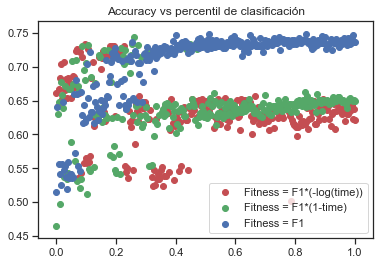

In [56]:
e = plt.figure(1)
plt.scatter(percentileList, validationAccuracyList[::-1], marker='o', color='r', label='Fitness = F1*(-log(time))')
plt.scatter(percentileList2, validationAccuracyList2[::-1], marker='o', color='g', label='Fitness = F1*(1-time)')
plt.scatter(percentileList3, validationAccuracyList3[::-1], marker='o', color='b', label='Fitness = F1')
plt.title('Accuracy vs percentil de clasificación')
plt.legend()
e.show()

/Users/joaquincubelli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


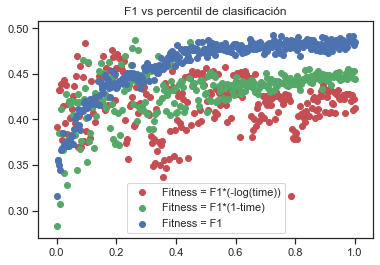

In [57]:
f = plt.figure(2)
plt.scatter(percentileList, validationF1List[::-1], marker='o', color='r', label='Fitness = F1*(-log(time))')
plt.scatter(percentileList2, validationF1List2[::-1], marker='o', color='g', label='Fitness = F1*(1-time)')
plt.scatter(percentileList3, validationF1List3[::-1], marker='o', color='b', label='Fitness = F1')
plt.title('F1 vs percentil de clasificación')
plt.legend()
f.show()

/Users/joaquincubelli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


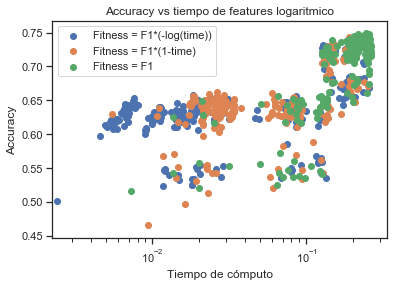

In [58]:
g = plt.figure(2)
plt.scatter(timeList, validationAccuracyList, label='Fitness = F1*(-log(time))') # Distribuición con tiempo logaritmico.
plt.scatter(timeList2, validationAccuracyList2, label='Fitness = F1*(1-time)') # Distribuición con tiempo logaritmico.
plt.scatter(timeList3, validationAccuracyList3, label='Fitness = F1') # Distribuición con tiempo logaritmico.plt.legend()
plt.legend()
plt.xscale('log')
plt.xlabel('Tiempo de cómputo')
plt.ylabel('Accuracy')
plt.title('Accuracy vs tiempo de features logaritmico')
g.show()

/Users/joaquincubelli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


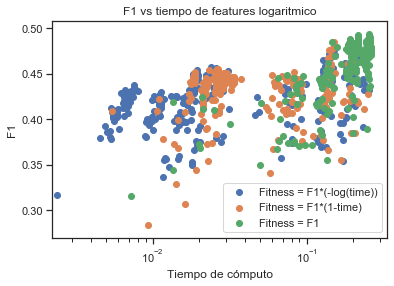

In [61]:
g = plt.figure(2)
plt.scatter(timeList, validationF1List, label='Fitness = F1*(-log(time))') # Distribuición con tiempo logaritmico.
plt.scatter(timeList2, validationF1List2, label='Fitness = F1*(1-time)') # Distribuición con tiempo logaritmico.
plt.scatter(timeList3, validationF1List3, label='Fitness = F1') # Distribuición con tiempo logaritmico.plt.legend()
plt.legend()
plt.xscale('log')
plt.xlabel('Tiempo de cómputo')
plt.ylabel('F1')
plt.title('F1 vs tiempo de features logaritmico')
g.show()

/Users/joaquincubelli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


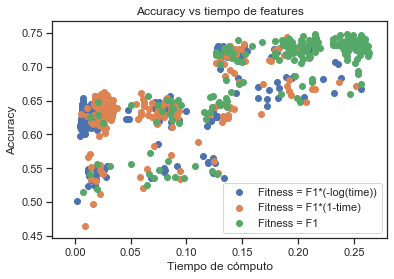

In [59]:
g = plt.figure(3)
plt.scatter(timeList, validationAccuracyList, label='Fitness = F1*(-log(time))') # Distribuición con tiempo logaritmico.
plt.scatter(timeList2, validationAccuracyList2, label='Fitness = F1*(1-time)') # Distribuición con tiempo logaritmico.
plt.scatter(timeList3, validationAccuracyList3, label='Fitness = F1') # Distribuición con tiempo logaritmico.
plt.legend()
plt.xlabel('Tiempo de cómputo')
plt.ylabel('Accuracy')
plt.title('Accuracy vs tiempo de features')
g.show()